# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf


from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(10)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [3]:
# project_location = "e:/projects/stloc/"
project_location = "./"

# Load data

## Spatial data

In [4]:
df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
cellTypeCount =16
typeCountDf=  df_st.iloc[:,-cellTypeCount:]
# df_st = df_st.iloc[: , :-cellTypeCount]
df_st.head()


,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.000000,0.631323,2.783859,4.017283,0.707772,2.754597,1.262664,14.922339,0.707772,0.0,...,0,0,0,1,1,0,0,0,0,0
1,0.000000,0.000000,5.027816,0.000000,0.000000,10.056050,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,3.856702,0.000000,0.854257,0.427118,0.0,...,0,0,0,1,1,0,0,0,0,0
3,0.000000,0.000000,1.465245,0.732607,0.000000,2.323503,0.795436,0.732607,0.732607,0.0,...,0,0,0,2,0,0,0,0,0,0
4,6.311896,7.574326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,1,0,0,1,0,0,0,0


In [5]:
typeCountDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [5]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")

reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [6]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount'])

In [7]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)


      cellcount
0             4
1             1
2             2
3             2
4             2
...         ...
1244          4
1245          1
1246          3
1247          5
1248          1

[1249 rows x 1 columns]
zero count is cellcount    0
dtype: int64


16

## Single-cell data

In [8]:
df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")

In [9]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN


In [10]:
obs_sc.shape
obs_sc.loc[0,"Cell_class"]

'Astrocyte'

# Tangram

In [11]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(6412, 155)
(1249, 155)


In [12]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [13]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:155 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:155 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [15]:
adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.508, KL reg: 0.152
Score: 0.983, KL reg: 0.001
Score: 0.988, KL reg: 0.000
Score: 0.989, KL reg: 0.000
Score: 0.989, KL reg: 0.000


INFO:root:Saving results..


In [16]:
print(adata_map_rna.to_df().shape)
adata_map_rna.to_df().head()

(6412, 1249)


,0,1,2,3,4,5,6,7,8,9,...,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248
0,4.472053e-08,2.748162e-07,1.382065e-06,3.561260e-07,3.717827e-07,3.484136e-07,4.229416e-07,8.515371e-07,1.759253e-07,6.389413e-07,...,4.229141e-07,8.734621e-08,1.664002e-07,1.316386e-07,1.425857e-07,7.232790e-07,1.048338e-07,9.958917e-01,1.507501e-07,1.116491e-07
1,5.830841e-07,6.436888e-08,2.506673e-07,1.434281e-07,3.463672e-07,1.640525e-06,9.299046e-08,4.287989e-07,4.374088e-07,1.233803e-07,...,2.348588e-06,3.013422e-07,5.734486e-06,9.633494e-07,3.530000e-07,3.136950e-07,4.639243e-07,9.971852e-01,1.351714e-06,2.889103e-07
2,9.224150e-08,1.448519e-07,2.774884e-07,2.830552e-07,2.239126e-07,2.226053e-07,1.228331e-06,2.650153e-06,9.643015e-08,6.366436e-07,...,5.634984e-07,1.320155e-07,3.204153e-07,8.456265e-07,2.395414e-07,4.286483e-06,5.329547e-07,4.657158e-07,9.979295e-01,5.871376e-07
3,1.856666e-07,1.538455e-07,8.225150e-08,2.151984e-07,7.393787e-07,1.505008e-06,1.056792e-06,1.405870e-06,1.210679e-07,2.536042e-06,...,9.245033e-08,1.950826e-07,2.600600e-07,1.041291e-06,1.175626e-07,1.941852e-07,7.553996e-07,9.524972e-07,9.974911e-01,3.560332e-07
4,4.302512e-06,7.432978e-07,1.048185e-06,5.952697e-07,6.825738e-07,1.914389e-06,2.081761e-06,3.482411e-05,1.458558e-06,1.857694e-06,...,1.251917e-05,1.291072e-06,1.092046e-06,1.469826e-05,1.252808e-06,1.179797e-06,2.824704e-06,4.677780e-06,6.804138e-06,3.193920e-06


In [17]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf= adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.507, KL reg: 0.107
Score: 0.986, KL reg: 0.000
Score: 0.990, KL reg: 0.000
Score: 0.991, KL reg: 0.000
Score: 0.991, KL reg: 0.000


INFO:root:Saving results..


In [18]:
probabilityDf.shape

(6412, 1249)

# probability analysis

In [19]:
np.argmax(probabilityDf.iloc[2])
probabilityDf.iloc[2,1247]

Nrows= len(df_st)
Ncols= len(celltypes)

deconvolveDf = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
for i in range(len(probabilityDf)):
    spotNo = np.argmax(probabilityDf.iloc[i])
    cellClass= obs_sc.loc[i,"Cell_class"]
    deconvolveDf.loc[spotNo,cellClass] = deconvolveDf.loc[spotNo,cellClass] +1


deconvolveDf.shape

(1249, 16)

In [20]:
deconvolveDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
for i in range(len(deconvolveDf)):
    deconvolveDf.iloc[i] = 100* deconvolveDf.iloc[i]/deconvolveDf.iloc[i].sum()



In [22]:
print(deconvolveDf.head())
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)


   Astrocyte  Inhibitory  Pericytes  Ambiguous  Endothelial1  Excitatory  \
0        0.0   28.571429        0.0   0.000000     28.571429         0.0   
1        0.0    0.000000        0.0   0.000000      0.000000         0.0   
2        0.0    0.000000        0.0   0.000000      0.000000         0.0   
3        0.0    0.000000        0.0  33.333333      0.000000         0.0   
4        0.0    0.000000        0.0   0.000000      0.000000         0.0   

   ODImmature1  ODImmature2  Microglia   ODMature2  ODMature1  Endothelial3  \
0          0.0          0.0        0.0   28.571429  14.285714           0.0   
1          0.0          0.0        0.0  100.000000   0.000000           0.0   
2          0.0          0.0        0.0   50.000000  50.000000           0.0   
3          0.0          0.0        0.0   66.666667   0.000000           0.0   
4          0.0          0.0       50.0    0.000000   0.000000          50.0   

   ODMature3  ODMature4  Endothelial2  Ependymal  
0        0.0     

Astrocyte       1
Inhibitory      1
Pericytes       1
Ambiguous       1
Endothelial1    1
Excitatory      1
ODImmature1     1
ODImmature2     1
Microglia       1
ODMature2       1
ODMature1       1
Endothelial3    1
ODMature3       1
ODMature4       1
Endothelial2    1
Ependymal       1
dtype: int64

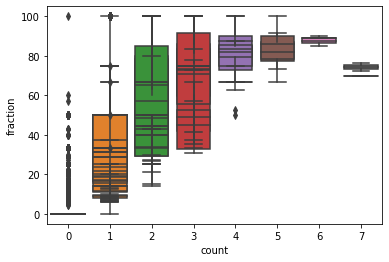

In [27]:
fig, ax = plt.subplots()
cellDict={}
outputDir="./output/merfish/tangram/"
for  c in celltypes:
    cellDict["count"]=typeCountDf[c]
    cellDict["fraction"]=deconvolveDf[c]
    df = pd.DataFrame(cellDict)
    sns.boxplot(x='count',y='fraction',data= df,ax=ax)
    fileName= outputDir  + c+".pdf"
    plt.savefig(fileName)





In [29]:
celltypes= ["Inhibitory"]
cellDict={}
for  c in celltypes:
    uniqueCounts= (typeCountDf[c].unique())
    uniqueCounts = uniqueCounts.sort()
    for val in uniqueCounts:
        cellDict[val]=[deconvolveDf.iloc[Index][c] for Index  in range(len(deconvolveDf))  if abs(typeCountDf.iloc[Index][c]-val)<0.0000001 ]
    # print(cellDict[0])

    fig, ax  = plt.subplots()
    ax.boxplot(cellDict.values())
    ax.set_xticklabels(cellDict.keys())

    scatterDict={
        "count": typeCountDf[c],
        "fraction":deconvolveDf[c],
    }
    scatterDf=pd.DataFrame(scatterDict)   
    ax1 = scatterDf.plot.scatter(x='count',
                      y='fraction',
                    )
    # pdf = matplotlib.backends.backend_pdf.PdfPages("./output/merfish/tangram2c"+c+".pdf")
    # pdf.savefig(ax)
    # pdf.savefig(ax1)
 



TypeError: 'NoneType' object is not iterable